# MNIST CNN Classifier
Adapted from the [mnist_cnn keras example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py) pointed to from the [AWS tutorial on containers](https://aws.amazon.com/getting-started/tutorials/train-deep-learning-model-aws-ec2-containers/):
```
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
```

Further adapted from Yan LeCunn's top performing MNIST paper:
[Regularization of Neural Networks using DropConnect](http://yann.lecun.com/exdb/publis/pdf/wan-icml-13.pdf)

# Setup libraries and parameters

In [0]:
import time
import imageio
import os.path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#from torch.autograd import Variable

In [0]:
# For confusion matrix and 2D embedding
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [0]:
import PIL
import itertools

In [5]:
try:
    # Run this cell to mount your Google Drive.
    data_path = '/content/drive'
    try:
        from google.colab import drive
        drive.mount(data_path)
    except:
        pass
    try:
        data_path = os.path.join(data_path, 'My Drive', 'checkpoints')
        !mkdir -p "$data_path"
    except:
        print('Couldn\'t create', data_path)
except:
    # Just write locally if not in Colaboratory
    data_path = './checkpoints'
print(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/checkpoints


In [0]:
# Control the resolution of figures plotted below. 200 dpi works well on my macbook
plt.rcParams['figure.dpi'] = 200

# Network definition
Adapted from this portion of the Keras example model
```
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
```
A few modifications:
* I changed the first layer to output 8 channels instead of 32, with the rationale being that a 3x3 kernel only spans 9 DOF. Any channels above 9 would start to become linearly dependent, but the nonlinearity after them might allow them to learn more?
* I added batch normalization after the first two convolutional layers because...well...everyone says they are helpful

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # weights = 1x8x3x3 = 72
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # weights = 8x64x3x3 = 4,608
        self.drop1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(12*12*64, 128)
        # weights = 12x12x64x128 = 1,179,648
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        # weights = 128 x 10 = 1280

    def forward(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        fc2 = self.fc2(self.drop2(fc1))
        # layer size 1x10
        # perf = 1280 mul adds
        return F.log_softmax(fc2, dim=1)
    
    # Output fc1 features
    def features(self, x):
        # layer size 28x28x1 = 784
        cl1 = F.relu(self.bn1(self.conv1(x)))
        # layer size 26x26x8 = 5,408
        # perf = 21,632 outputs x 288 kernel entries = 6,230,016 mul adds
        cl2 = F.relu(self.bn2(self.conv2(cl1)))
        # layer size 24x24x64 = 36,864
        # perf = 36,864 outputs x 589,824 kernel entries = 21,743,271,936 mul adds
        mp = F.max_pool2d(cl2, 2, 2)
        # layer size 12x12x64 = 9216
        mp_d = self.drop1(mp)
        # layer size 1x12*12*64 = 9216
        fc1 = F.relu(self.fc1(mp_d.view(-1, 12*12*64)))
        # layer size 1x128
        # perf = 1,179,648 mul adds
        return fc1

In [0]:
class Optimizer:
    def __init__(self,
                 seed=1,
                 no_cuda=False,
                 #load_checkpoint=12,
                 load_checkpoint=False,
                 checkpoint_path='.'):
        
        self.batch_size=120
        self.test_batch_size=1000
        self.epochs=1000
        self.lr=0.01
        self.momentum=0.5
        self.log_interval=250
        
        self.checkpoint_path = checkpoint_path
        self.save_checkpoints=True
            
        self.epoch = 0
        
        torch.manual_seed(seed)

        use_cuda = not no_cuda and torch.cuda.is_available()
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = Net().to(self.device)
        
        #self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum)
        #self.optimizer = optim.Adadelta(self.model.parameters(), lr=self.lr)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_criterion = nn.CrossEntropyLoss(reduction='sum')

        if load_checkpoint:
            self.load_checkpoint(load_checkpoint)
            self.test(test_loader)

    def set_optimizer(self, lr):
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        
    def train(self, train_loader):
        # Set model to be in training mode
        self.model.train()
        
        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        mini_batch_losses = []
        for data, target in train_loader:
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = self.loss_criterion(output, target)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            mini_batch_losses.append(loss.item())

        return total_loss, correct, mini_batch_losses
        
    def test(self, test_loader):
        # Set model to be in testing mode
        self.model.eval()

        # Accuracy accumulator 
        correct = 0
        total_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)

                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                total_loss += self.loss_criterion(output, target).item() # sum up batch loss

        return total_loss, correct

    def run_epoch(self, train_loader, test_loader):
        train_start = time.perf_counter()
        train_loss, train_correct, mini_batch_losses = self.train(train_loader)
        train_end = time.perf_counter()
        train_count = len(train_loader.dataset)
        train_delta = train_end - train_start

        test_start = time.perf_counter()
        test_loss, test_correct = self.test(test_loader)
        test_end = time.perf_counter()
        test_count = len(test_loader.dataset)
        test_delta = test_end - test_start

        print('{:5d} | {:5.1f}s, {:4.1f}s | {:6.4f}, {:6.4f} | {:5d}/{:5d} ({:.2f}%), {:4d}/{:4d} ({:5.2f}%)'.format(
            self.epoch,
            train_delta, test_delta,
            train_loss/train_count, test_loss/test_count,
            train_correct, train_count, 100. * train_correct / train_count,
            test_correct, test_count, 100. * test_correct / test_count))
        
        self.epoch = self.epoch + 1
        
        if self.save_checkpoints:
            self.save_checkpoint(losses)

        return mini_batch_losses
        
    def run(self, train_loader, test_loader, epochs=False):
        
        if not epochs:
            epochs = self.epochs

        print('Epoch | Time          | Loss           | Accuracy')
        print('      | Train,  Test  | Train,  Test   | Train,                Test')
        for epoch in range(epochs):
            losses = self.run_epoch(train_loader, test_loader)
    
    def save_checkpoint(self, losses=[], prefix='mnist_'):
        checkpoint = {'epoch' : self.epoch,
                      'losses' : losses,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict' : self.optimizer.state_dict(),
                      'loss_criterion' : self.loss_criterion}
        torch.save(checkpoint, os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(prefix, self.epoch)))

    def load_checkpoint(self, epoch, prefix='mnist_'):
        checkpoint = torch.load(os.path.join(self.checkpoint_path, '{}{:03}.pth'.format(prefix, epoch)))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_criterion = checkpoint['loss_criterion']
        for parameter in self.model.parameters():
            parameter.requires_grad = False
        return checkpoint['losses']

In [0]:
opt = Optimizer(checkpoint_path=data_path)

## Network Graph Plotting
These are the graph of functions back propagated through during the call to backward. This is adapted from the [PyTorch tutorial documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

In [0]:
# depth-first search through the back prop functions
def print_graph(fn, depth=0):
    if fn is None:
        return

    print('|'*depth, type(fn).__name__)
    for i in range(len(fn.next_functions)):
        print_graph(fn.next_functions[i][0], depth+1)

In [11]:
# Generate a random input and run it forward
batch_size = 1
input = torch.randn(batch_size,1,28,28).to(opt.device)
output = opt.model(input)

# Run the backward pass, which generates the graph
opt.model.zero_grad()
output.backward(torch.randn(batch_size,10).to(opt.device))

# Print the graph
print_graph(output.grad_fn)

 LogSoftmaxBackward
| AddmmBackward
|| AccumulateGrad
|| FusedDropoutBackward
||| ReluBackward0
|||| AddmmBackward
||||| AccumulateGrad
||||| ViewBackward
|||||| FusedDropoutBackward
||||||| MaxPool2DWithIndicesBackward
|||||||| ReluBackward0
||||||||| CudnnBatchNormBackward
|||||||||| CudnnConvolutionBackward
||||||||||| ReluBackward0
|||||||||||| CudnnBatchNormBackward
||||||||||||| CudnnConvolutionBackward
|||||||||||||| AccumulateGrad
|||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
||||||||||| AccumulateGrad
|||||||||| AccumulateGrad
|||||||||| AccumulateGrad
||||| TBackward
|||||| AccumulateGrad
|| TBackward
||| AccumulateGrad


## Print Model Parameter Sizes
How many weights/parameters are there in each expression (portion of a layer) that contribute to the gradient?

In [0]:
def print_model_size(model):
    total_model_size = 0
    print("Model's state_dict:")
    # print out size of each set of parameter
    for param_tensor in model.state_dict():
        sz = model.state_dict()[param_tensor].size()

        # skip empty parameters (like batch normalization history length)
        if len(sz) == 0:
            continue

        total_model_size += np.prod(sz)
        if len(sz) > 1:
            print('{:16s} {:26s} : {} x {} = {:,}'.format(param_tensor, str(sz), sz[0], np.prod(sz[1:]), np.prod(sz)))
        else:
            print('{:16s} {:26s} : {:,}'.format(param_tensor, str(sz), np.prod(sz)))

    # print out total
    print('\n{:43} : {:,}'.format('Total Model Size',total_model_size))

In [13]:
 print_model_size(opt.model)

Model's state_dict:
conv1.weight     torch.Size([32, 1, 3, 3])  : 32 x 9 = 288
conv1.bias       torch.Size([32])           : 32
bn1.weight       torch.Size([32])           : 32
bn1.bias         torch.Size([32])           : 32
bn1.running_mean torch.Size([32])           : 32
bn1.running_var  torch.Size([32])           : 32
conv2.weight     torch.Size([64, 32, 3, 3]) : 64 x 288 = 18,432
conv2.bias       torch.Size([64])           : 64
bn2.weight       torch.Size([64])           : 64
bn2.bias         torch.Size([64])           : 64
bn2.running_mean torch.Size([64])           : 64
bn2.running_var  torch.Size([64])           : 64
fc1.weight       torch.Size([128, 9216])    : 128 x 9216 = 1,179,648
fc1.bias         torch.Size([128])          : 128
fc2.weight       torch.Size([10, 128])      : 10 x 128 = 1,280
fc2.bias         torch.Size([10])           : 10

Total Model Size                            : 1,200,266


# DataLoaders|
Wrap dataset downloaders in a DataLoader class

In [0]:
# DataLoaders for train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(10,translate=(0.1,0.1),scale=(0.9,1.1),shear=None,resample=PIL.Image.BILINEAR),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.batch_size, shuffle=True, **opt.kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.test_batch_size, **opt.kwargs)

# Train (or load) the network

In [15]:
opt.run(train_loader, test_loader)

Epoch | Time          | Loss           | Accuracy
      | Train,  Test  | Train,  Test   | Train,                Test
    1 |  16.2s,  1.3s | 0.7422, 0.0933 | 46400/60000 (77.33%), 9758/10000 (97.58%)
    2 |  16.7s,  1.3s | 0.2889, 0.0605 | 54987/60000 (91.64%), 9830/10000 (98.30%)
    3 |  16.5s,  1.3s | 0.2154, 0.0475 | 56214/60000 (93.69%), 9867/10000 (98.67%)
    4 |  16.5s,  1.3s | 0.1825, 0.0416 | 56826/60000 (94.71%), 9880/10000 (98.80%)
    5 |  16.3s,  1.3s | 0.1586, 0.0392 | 57191/60000 (95.32%), 9882/10000 (98.82%)
    6 |  16.6s,  1.3s | 0.1430, 0.0349 | 57508/60000 (95.85%), 9891/10000 (98.91%)
    7 |  16.2s,  1.3s | 0.1311, 0.0317 | 57687/60000 (96.14%), 9897/10000 (98.97%)
    8 |  16.5s,  1.3s | 0.1259, 0.0276 | 57752/60000 (96.25%), 9918/10000 (99.18%)
    9 |  16.4s,  1.3s | 0.1202, 0.0326 | 57881/60000 (96.47%), 9895/10000 (98.95%)
   10 |  16.7s,  1.3s | 0.1113, 0.0276 | 58018/60000 (96.70%), 9916/10000 (99.16%)
   11 |  16.3s,  1.3s | 0.1072, 0.0292 | 58082/60000

# Visualization Code

## Create a 2800 x 2800 tiled image from the 10,000 test images

In [0]:
def tile_digits(digits, outputs=None, shape='Square', train=False):
    ds = datasets.MNIST('../data', train=train, transform=transforms.Compose([
                           transforms.ToTensor()]))

    cmap = mpl.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)
    
    def get_img(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < -10:
            return np.zeros((28,28,3)).astype('uint8')
        
        idx = digits[idx]
        if idx < 0:
            clr = cmap(-idx-1)
            img = np.full((28,28,1), 255)
        else:
            clr = cmap(ds[idx][1])
            img = ds[idx][0].numpy().reshape(28,28)*255
            
        return np.dstack([(img*clr[c]).astype('uint8') for c in range(3)])

    def get_target(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return ds[digits[idx]][1]

    def get_class(idx):
        if idx >= len(digits) or idx < 0 or digits[idx] < 0:
            return -1
        return outputs[digits[idx]].argmax(dim=0, keepdim=True).numpy().T[0]

    cnt = len(digits)
    if shape is 'Square':
        cols = np.ceil(np.sqrt(cnt)).astype('int64')
    elif shape is 'Horizontal':
        cols = cnt
    else:
        cols = 1

    img = np.vstack([np.hstack([get_img(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    targets = np.vstack([np.hstack([get_target(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])
    if outputs is None:
        return img, targets
    else:
        classes = np.vstack([np.hstack([get_class(off+col) for col in range(cols)]) for off in range(0, cnt, cols)])

    return img, targets, classes

In [0]:
tiled, target = tile_digits(range(10000))
imageio.imwrite('tiled.png', tiled)

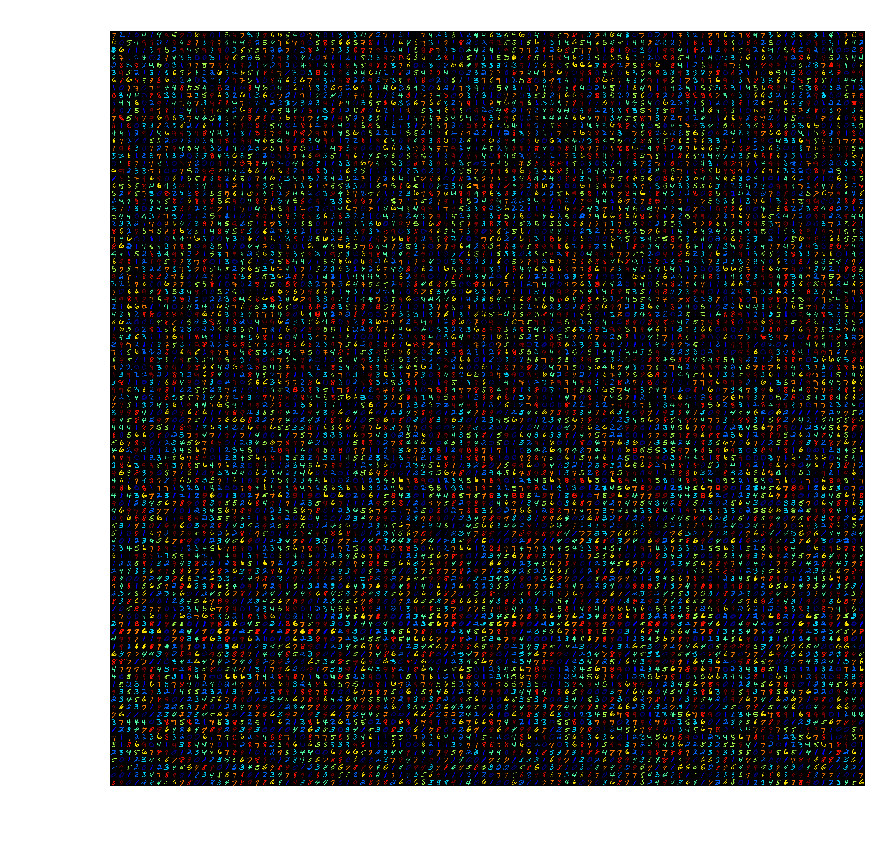

In [18]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(tiled)
plt.show()

## Inspect Failures

In [0]:
def get_failures(model, device, test_loader):
    model.eval()

    batch_offset = 0
    failure_indices = []
    target_all = torch.zeros((0),dtype=torch.long).to(device)
    output_all = torch.zeros((0,10)).to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            target_all = torch.cat((target_all, target))
            output_all = torch.cat((output_all, output))

            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            idx = np.where(pred.ne(target.view_as(pred)).to(torch.device("cpu")))[0]
            failure_indices += list(idx + batch_offset)
            
            batch_offset += pred.size(0)
    return np.array(failure_indices), output_all, target_all

In [0]:
failure_indices, output_all, target_all = get_failures(opt.model, opt.device, test_loader)

In [31]:
target_failures = target_all[failure_indices]
failure_idx_by_digit = list(map(lambda digit: np.where(target_failures.eq(digit).to(torch.device("cpu")))[0], range(0,10)))

# Print sorted failures
sorted_failures = np.hstack(failure_idx_by_digit)
fail_img, targets, classes = tile_digits(failure_indices[sorted_failures], output_all.to(torch.device("cpu")))

print(len(failure_indices))
print('Classifications:\n', classes)
imageio.imwrite('sorted_failures.png', fail_img)


39
Classifications:
 [[ 7  3  2  7  6  0  7]
 [ 5  5  8  6  9  3  3]
 [ 3  6  5  0  8  5  0]
 [ 1  1  2  2  9  3  0]
 [ 7  2  8  4  4  4  2]
 [ 4  4  4  8 -1 -1 -1]]


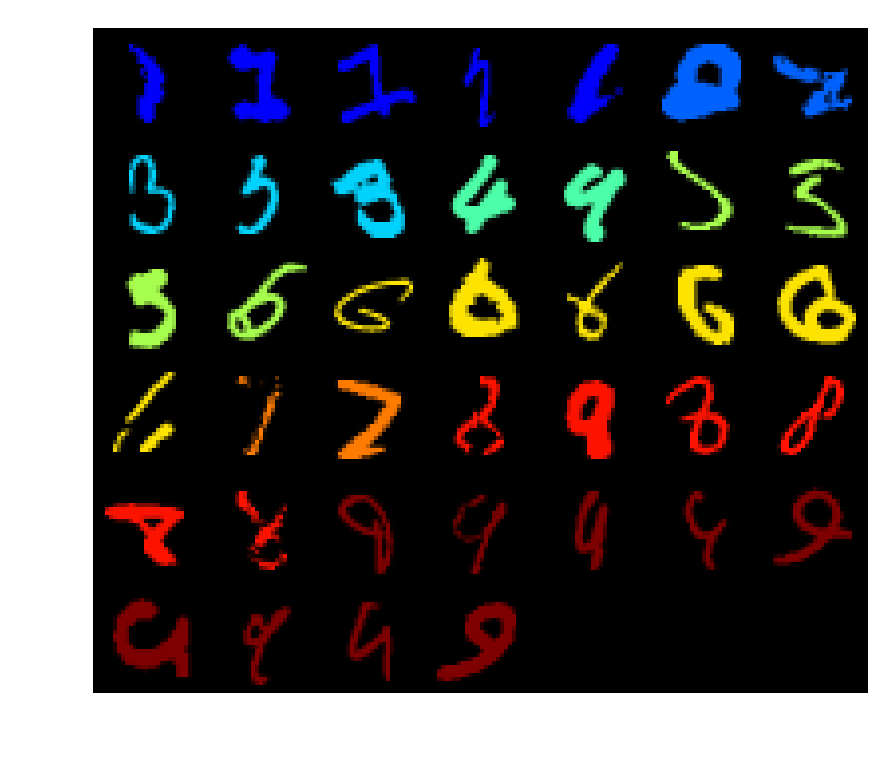

In [32]:
fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
plt.imshow(fail_img)
plt.show()

## Plot t-SNE embedding of fc1 features
First extract the fc1 features for each test image and their ground truth values

In [0]:
def get_fc1_features(model, device, dataloader):
    # Set model to be in testing mode
    model.eval()
    with torch.no_grad():
        x = list(map(lambda x: (model.features(x[0].to(device)), x[1].to(device)), dataloader))
        fc1 = torch.cat(list(map(lambda x: x[0].to(torch.device("cpu")), x))).detach().numpy()
        target = torch.cat(list(map(lambda x: x[1].to(torch.device("cpu")), x))).detach().numpy()
        return fc1, target

In [0]:
fc1, target=get_fc1_features(opt.model, opt.device, test_loader)

Embed the 128 dimensional fc1 features in 2D space

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(fc1)

Plot the 2D embedding, color-coded by the ground truth value

10000

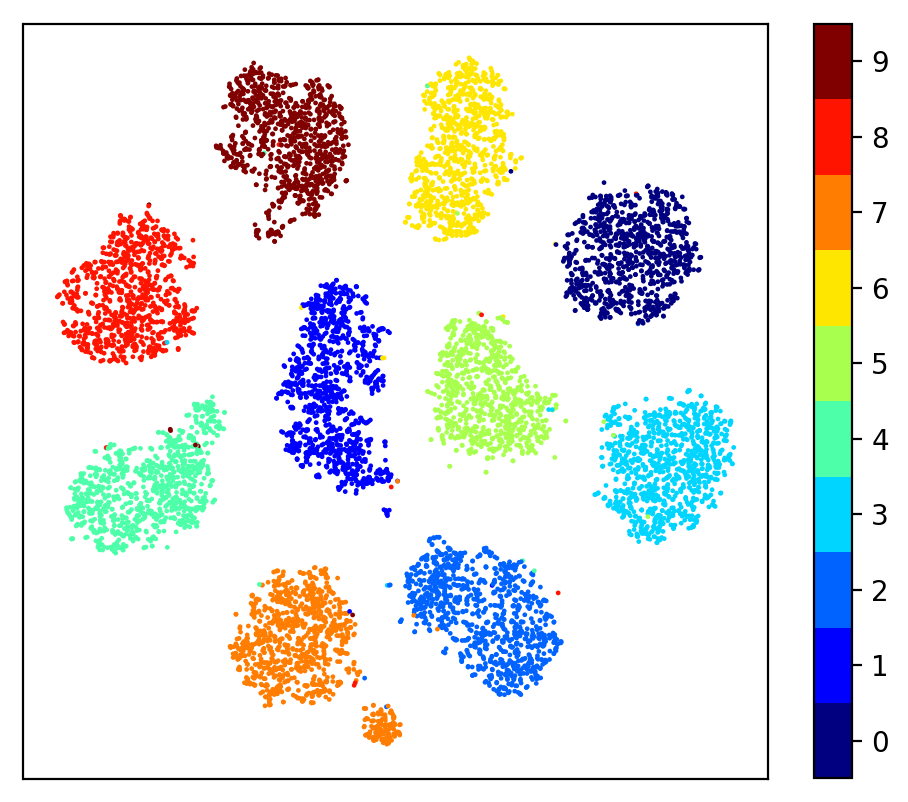

In [38]:
cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

#def onclick(event):
#    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
#          ('double' if event.dblclick else 'single', event.button,
#           event.x, event.y, event.xdata, event.ydata))

fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

#cid = fig.canvas.mpl_connect('button_release_event', onclick)

cs=ax0.scatter(X_embedded[:,0], X_embedded[:,1],
               norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5),
               s=.5, c=target, cmap=cmap)

cb = plt.colorbar(cs, ax=ax0)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])


#ax[1].set_xticks([])
#ax[1].set_yticks([])


len(target)

### How about just 4, 7 and 9

In [0]:
lst = [4,7,9]
fc1_sub=fc1[np.isin(target,lst),:]
target_sub=target[np.isin(target,lst)]

In [0]:
X_embedded_sub = TSNE(n_components=2).fit_transform(fc1_sub)

3019

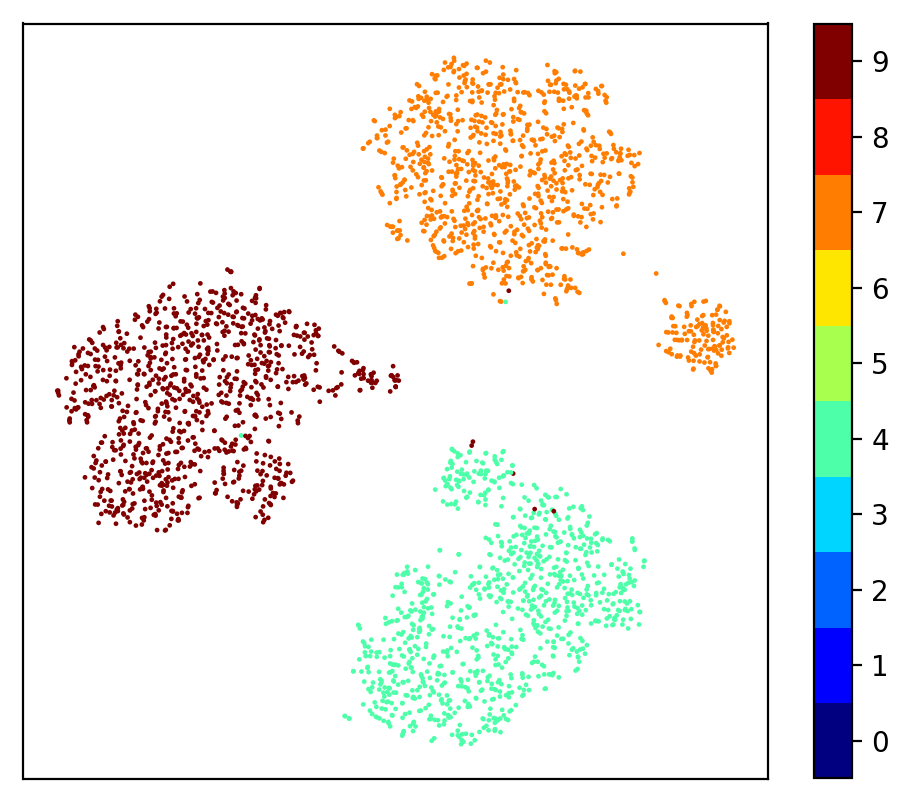

In [41]:
fig, (ax0) = plt.subplots(1,1, figsize=(6,5), dpi=200)

cmap = mpl.cm.jet
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, N=10)

cs=plt.scatter(X_embedded_sub[:,0], X_embedded_sub[:,1], s=.5, c=target_sub, cmap=cmap, norm=mpl.colors.Normalize(vmin=-0.5, vmax=9.5))
cb = plt.colorbar(cs)
cb.set_ticks(np.arange(0,10))
cb.set_ticklabels(np.arange(0, 10))

ax0.set_xticks([])
ax0.set_yticks([])
len(target_sub)

## What are the Nearest Neighbors for Failures?

In [0]:
# DataLoaders for train and test data
train_loader_fc1 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=opt.batch_size, shuffle=False, **opt.kwargs)

train_fc1, train_target=get_fc1_features(opt.model, opt.device, train_loader_fc1)

In [0]:
nbrs = NearestNeighbors(n_neighbors=16, algorithm='ball_tree').fit(train_fc1)
distances, indices = nbrs.kneighbors(fc1[failure_indices[sorted_failures],:])

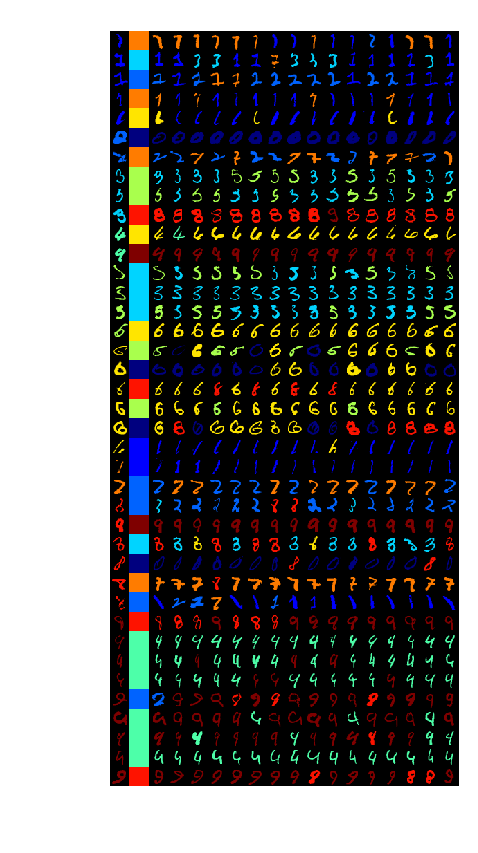

In [46]:
cnt = len(sorted_failures)

failure_classes = output_all[failure_indices[sorted_failures]].argmax(dim=1, keepdim=True) # get the index of the max log-probability

failure_img = tile_digits(failure_indices[sorted_failures], shape='Vertical')[0]
failure_classification_img = tile_digits((-failure_classes.to(torch.device("cpu")).numpy()-1).transpose()[0], shape='Vertical')[0]
neigh_img = np.vstack([tile_digits(indices[idx,:], shape='Horizontal', train=True)[0] for idx in range(cnt)])

imageio.imwrite('neighbors_train.png', np.hstack([failure_img, failure_classification_img, neigh_img]))

fig, ax=plt.subplots(figsize=(5,5), dpi=200)
ax.axis('off')
ax.imshow(np.hstack([failure_img, failure_classification_img, neigh_img]))

plt.show()

## Plot Confusion Matrix
The confusion matrix plotting function was copied from [Yassine Ghouzam's great notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

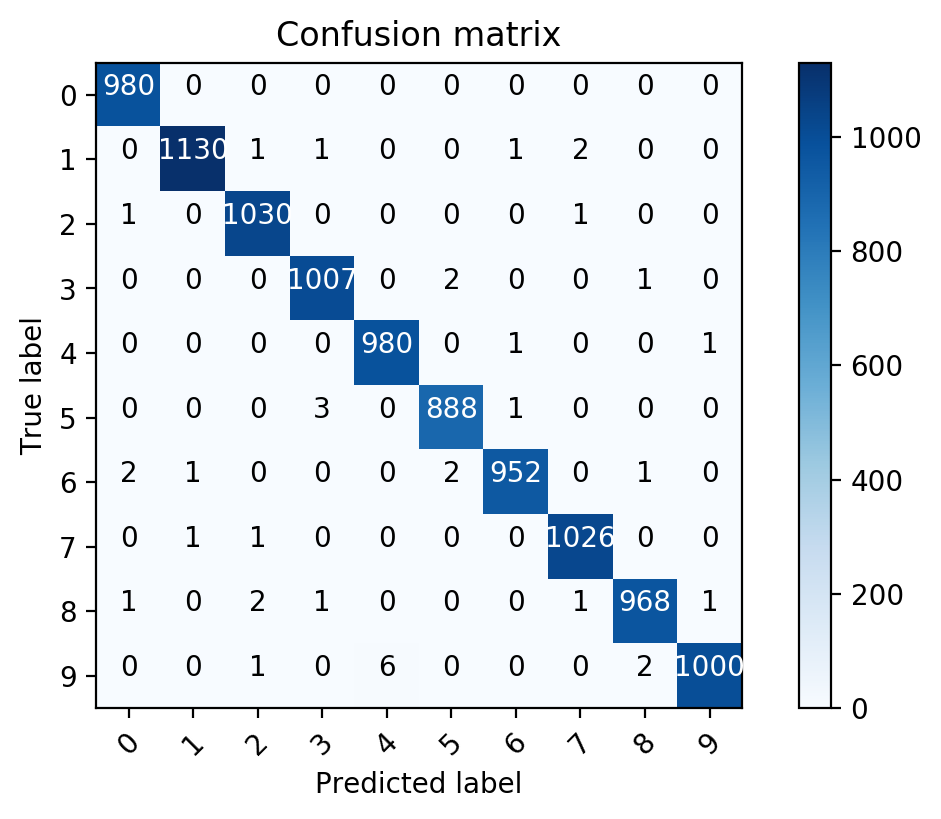

In [50]:
pred_all = output_all.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
# compute the confusion matrix
confusion_mtx = confusion_matrix(target_all.to(torch.device("cpu")), pred_all.to(torch.device("cpu"))) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Look at weights/kernels

In [0]:
def plot_kernels(conv_layer):
    out_dim = conv_layer.size()[0]
    in_dim = conv_layer.size()[1]
    kw = conv_layer.size()[2]
    kh = conv_layer.size()[3]
    #np.linalg.svd()

    for row in range(0,out_dim):
        fig, ax = plt.subplots(1, in_dim)
        for col in range(0,in_dim):
            if in_dim>1:
                col_ax = ax[col]
            else:
                col_ax = ax
            col_ax.imshow(conv_layer[row][col].numpy(), cmap='binary')
            col_ax.axis('off')
        plt.show()

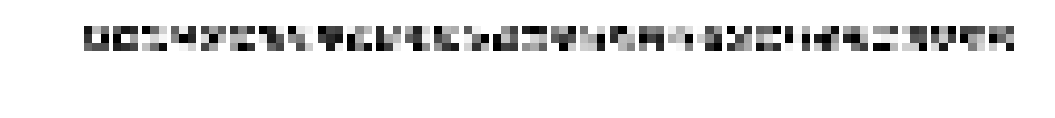

In [53]:
plot_kernels(opt.model.state_dict()['conv1.weight'].permute(1,0,2,3).to(torch.device("cpu")))

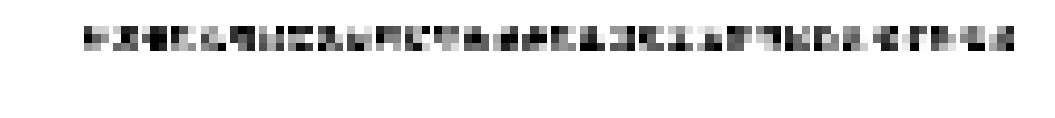

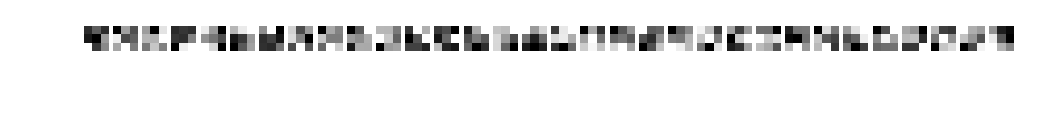

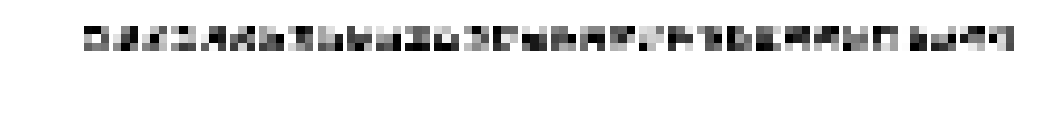

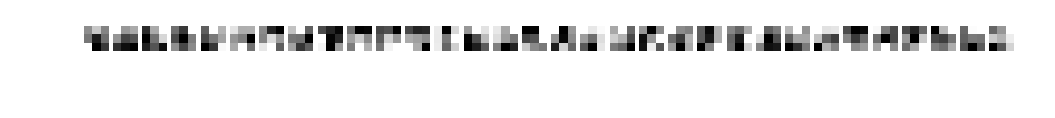

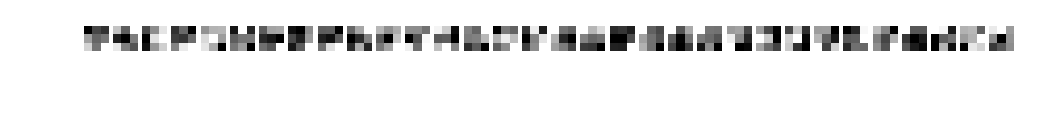

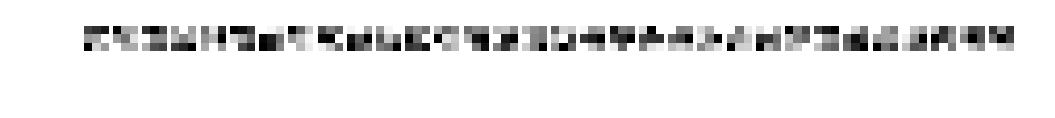

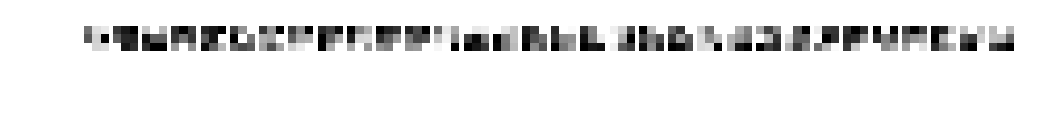

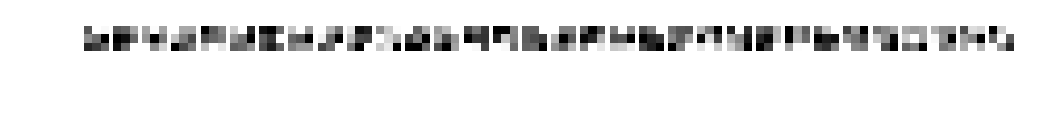

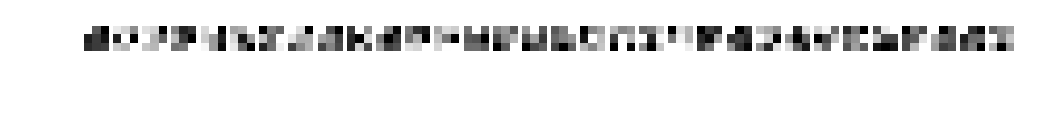

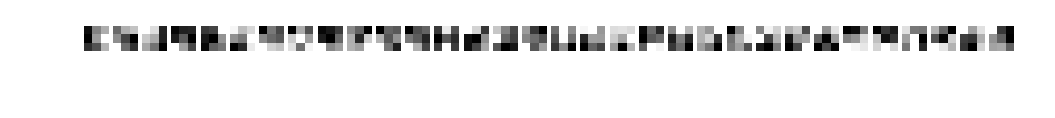

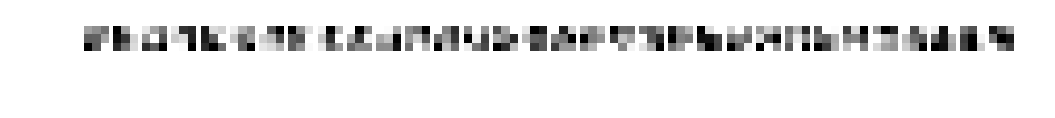

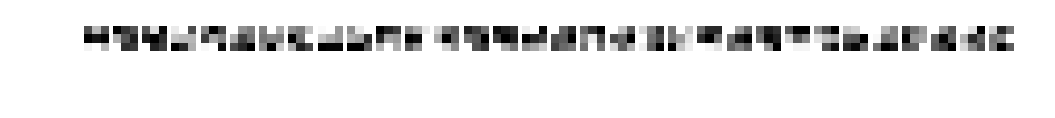

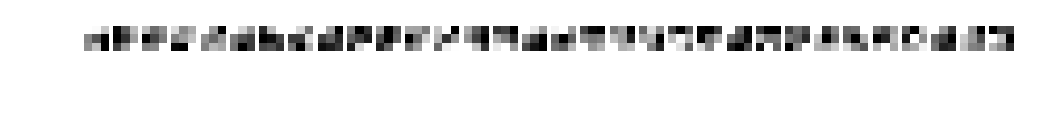

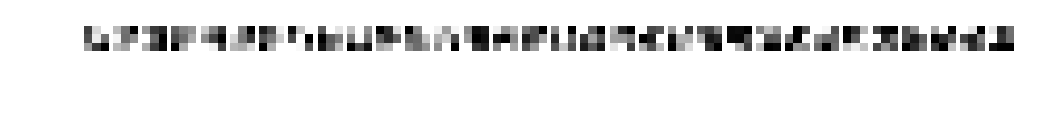

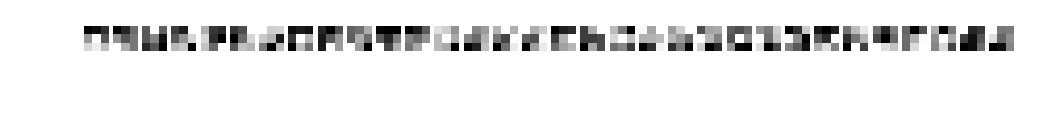

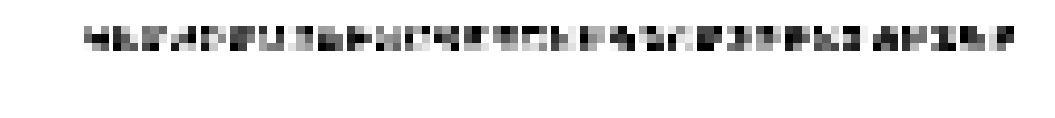

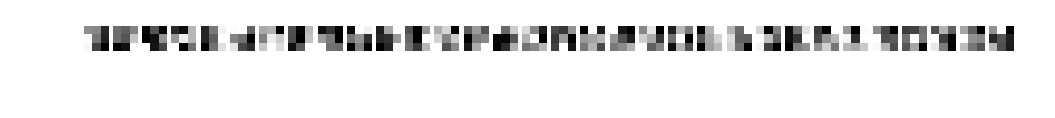

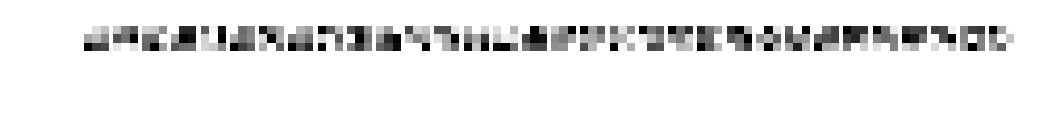

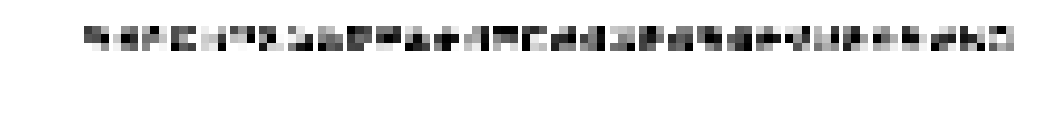

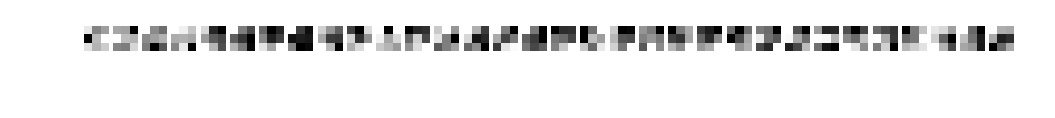

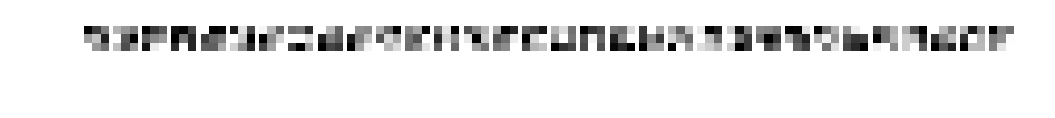

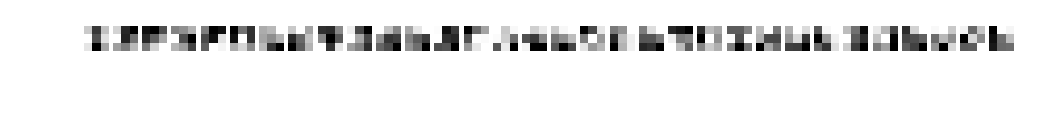

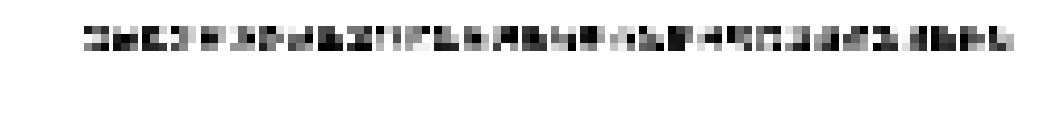

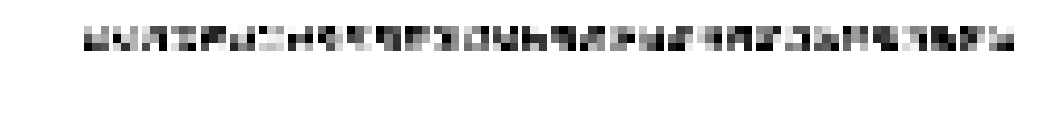

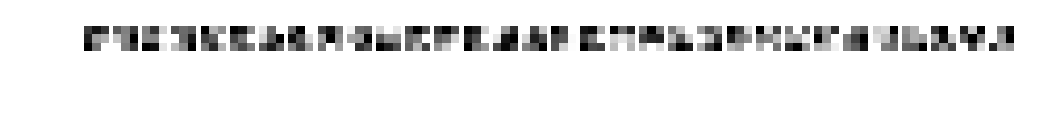

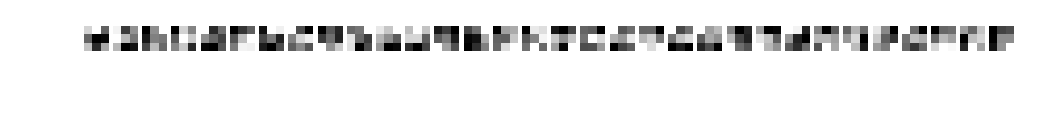

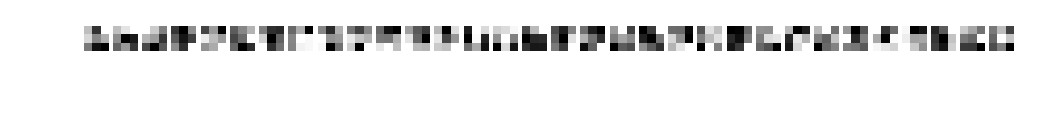

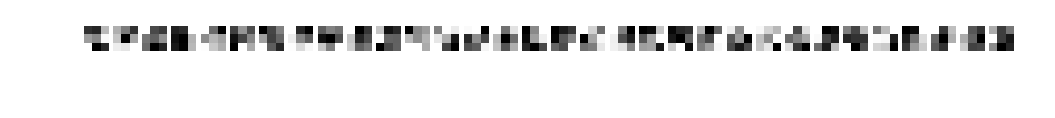

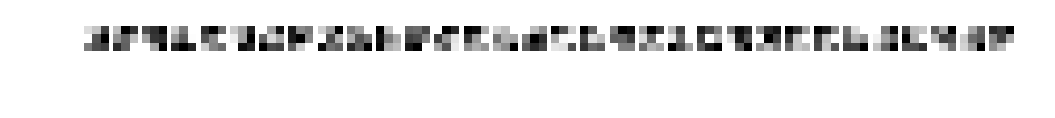

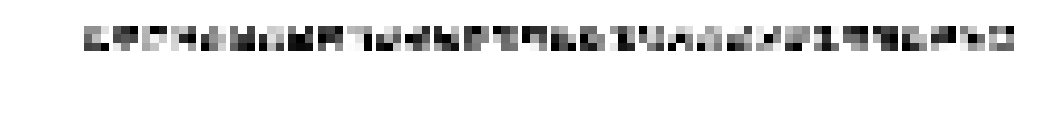

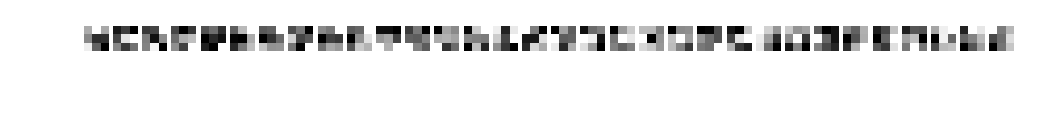

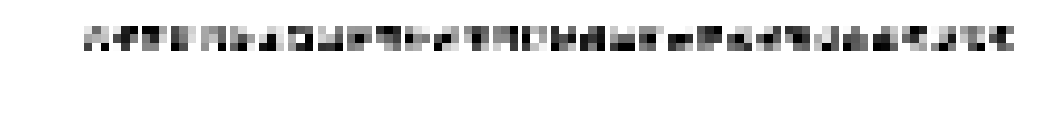

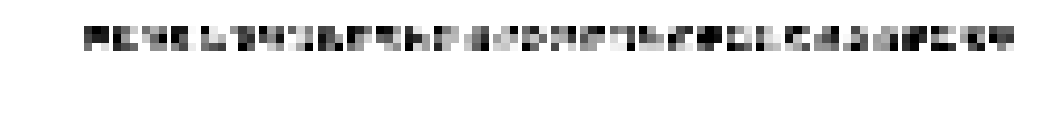

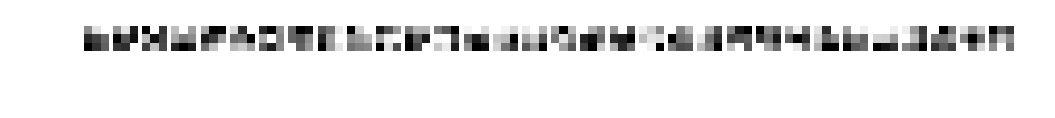

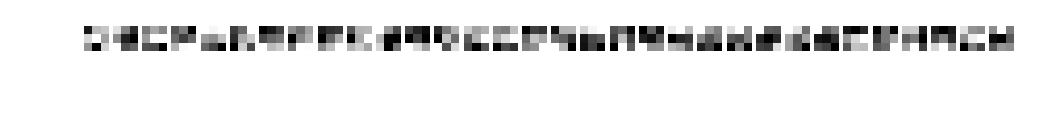

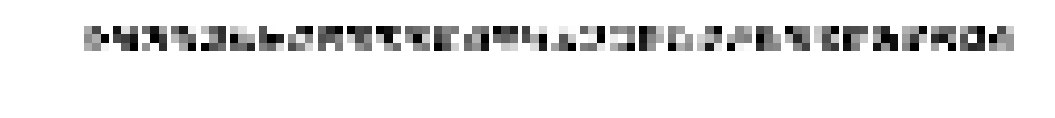

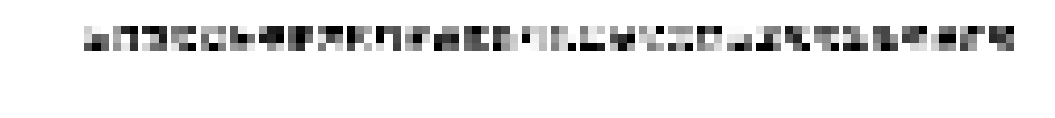

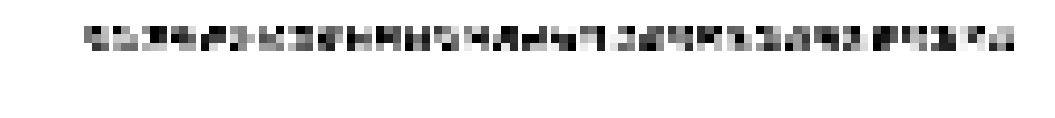

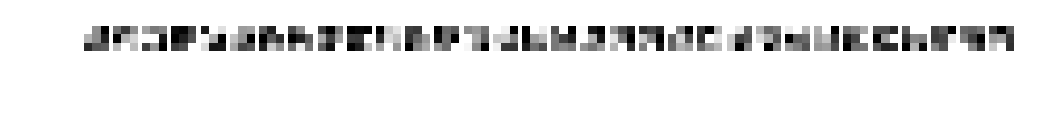

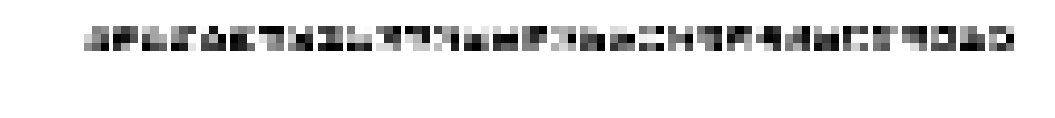

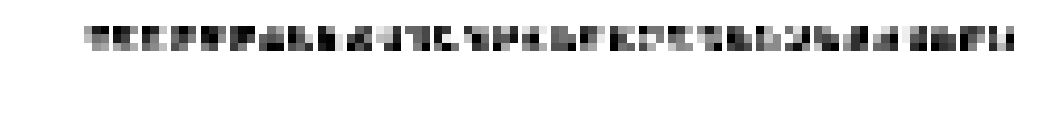

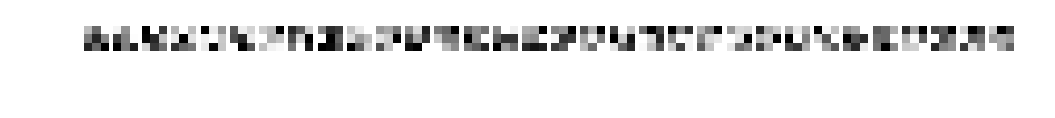

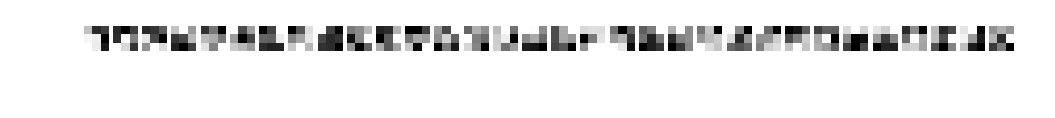

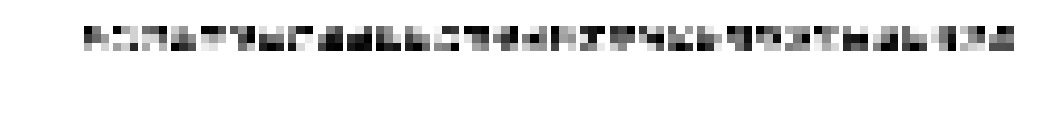

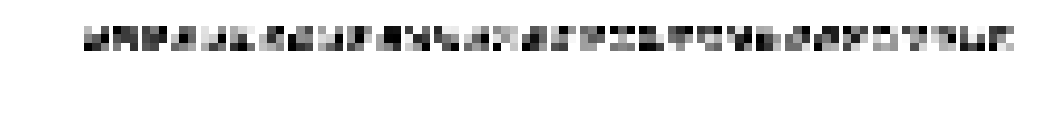

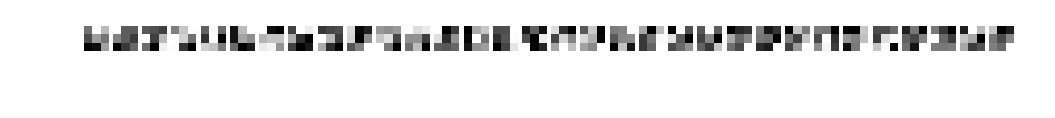

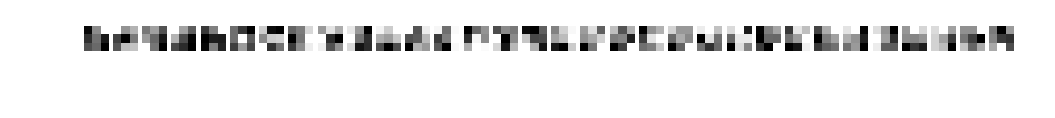

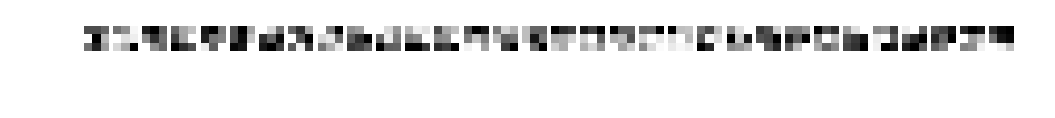

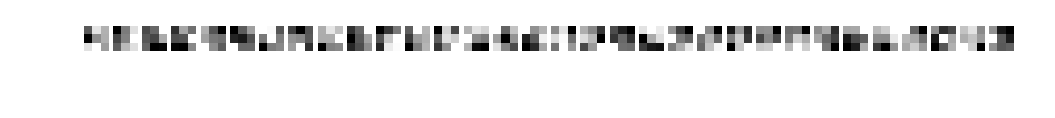

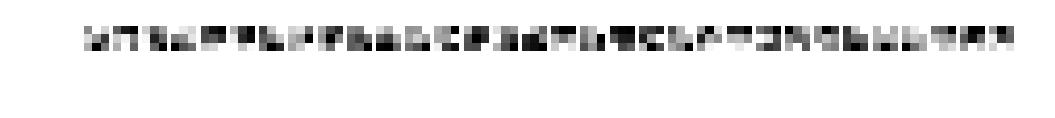

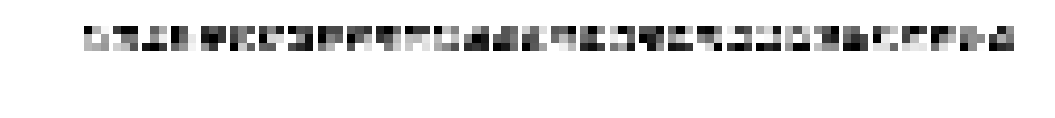

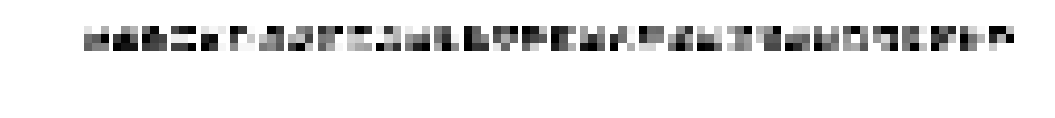

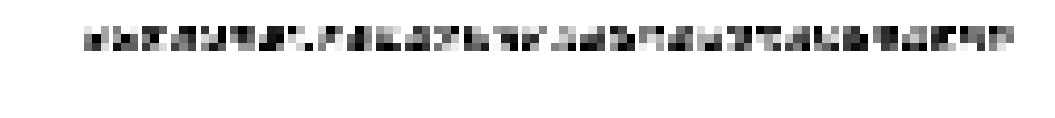

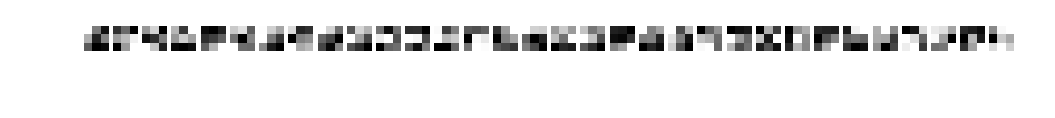

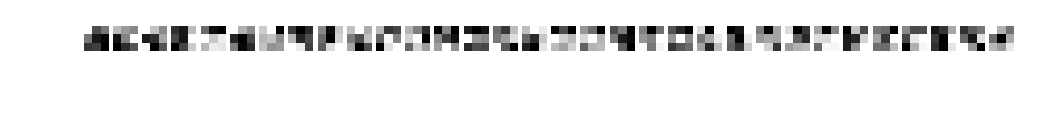

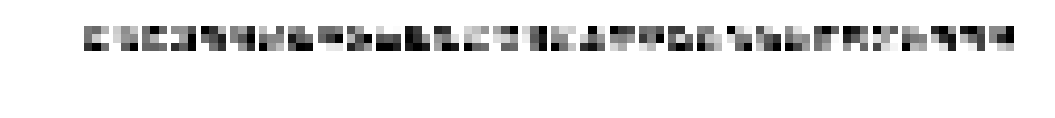

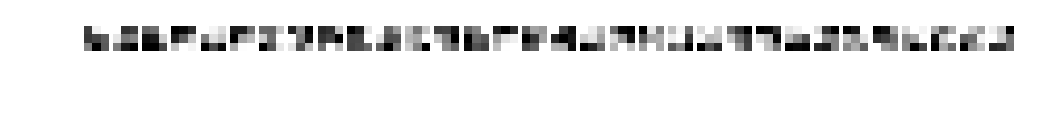

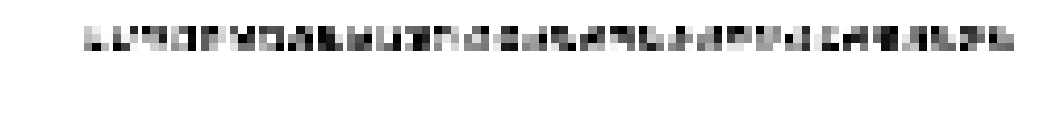

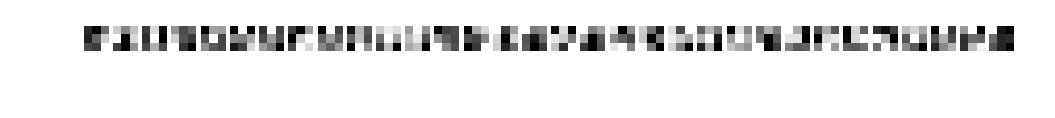

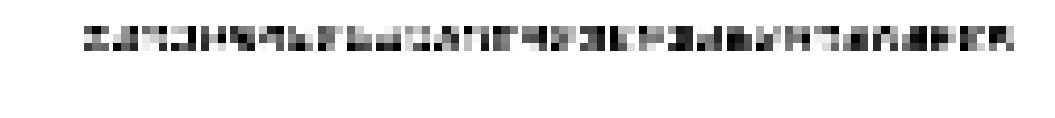

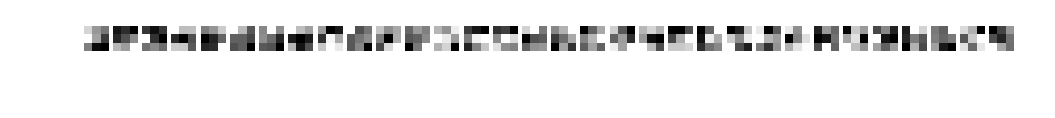

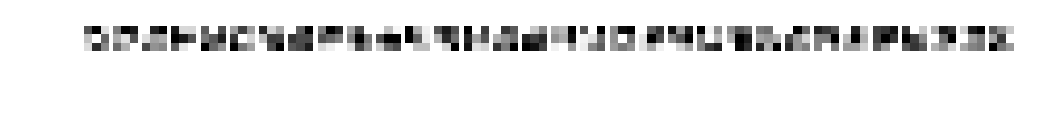

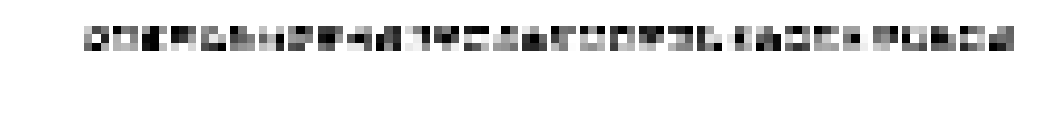

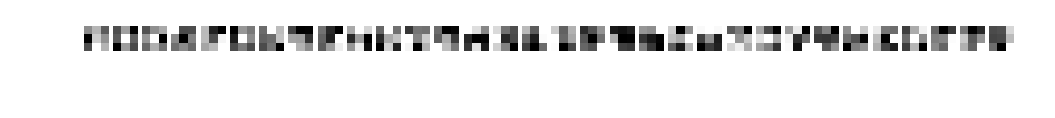

In [54]:
plot_kernels(opt.model.state_dict()['conv2.weight'].to(torch.device("cpu")))